In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
import warnings
from multiprocessing import Pool
import csv
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings("ignore")
import gc
%matplotlib inline

This jupyter notebook aims to use text data and metadata about wine to create a regression model in which we predict the points a wine taster gives to a specific wine. The dataset comes with information regarding the country, province, region, who the taster is, data about the wine itself, etc.

### Read in Data

In [2]:
winereviews = pd.read_csv('winemag-data-130k-v2.csv').drop('Unnamed: 0',axis=1)


### Data Visualization

When we build a regression model we want to explore the data in its entireity. For this part of the jupyter notebook, I will visualize the data before preprocessing.

Text(0.5,1,'Does Price Imply Better Wine? $r$=0.612')

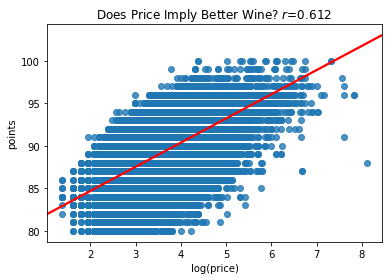

In [3]:
# correlation between points and price
slope, intercept, r_value, p_value, std_err = linregress(x=np.log(winereviews['price'].loc[pd.notna(winereviews['price'])]),y=winereviews['points'].loc[pd.notna(winereviews['price'])])

sns.regplot(x=np.log(winereviews['price'].loc[pd.notna(winereviews['price'])]),y=winereviews['points'].loc[pd.notna(winereviews['price'])],line_kws={"color":"r"})
plt.xlabel('log(price)')
plt.title(f'Does Price Imply Better Wine? $r$={round(r_value,3)}')

A common idea is that the more expensive the bottle of wine is the better the wine itself is. Here I explore and can confirm this trend. There is a clear correlation between the log of the price of wine and the points the reviewer gives. However, if we square the r-value (otherwise known as pearson's correlation coefficient) the $r^2$ is much lower. This is supported qualitatively by the model. Even though there is a positive trend, the data is not fit well by the line.

I plot two quantitative variables here: the natural log of the price and the points variable. When plotting two quantitative variables the best encoding is to use a scatterplot, as we can effectively display the relationship between two quantitative variables that way. The mark used to show (log(price),points) is a point. The channel we use is position for the points as we want to compare how the changes in price affect the points. I also plot a regression line to show the trend of the data. I use the color red to encode the line in order to avoid occlusion. The mark we use here is a line and the channel we encode is also position as we want to see how the trend line behaves as one moves up or down the x-axis.

Text(0.5,1,'Where are the best wines located?')

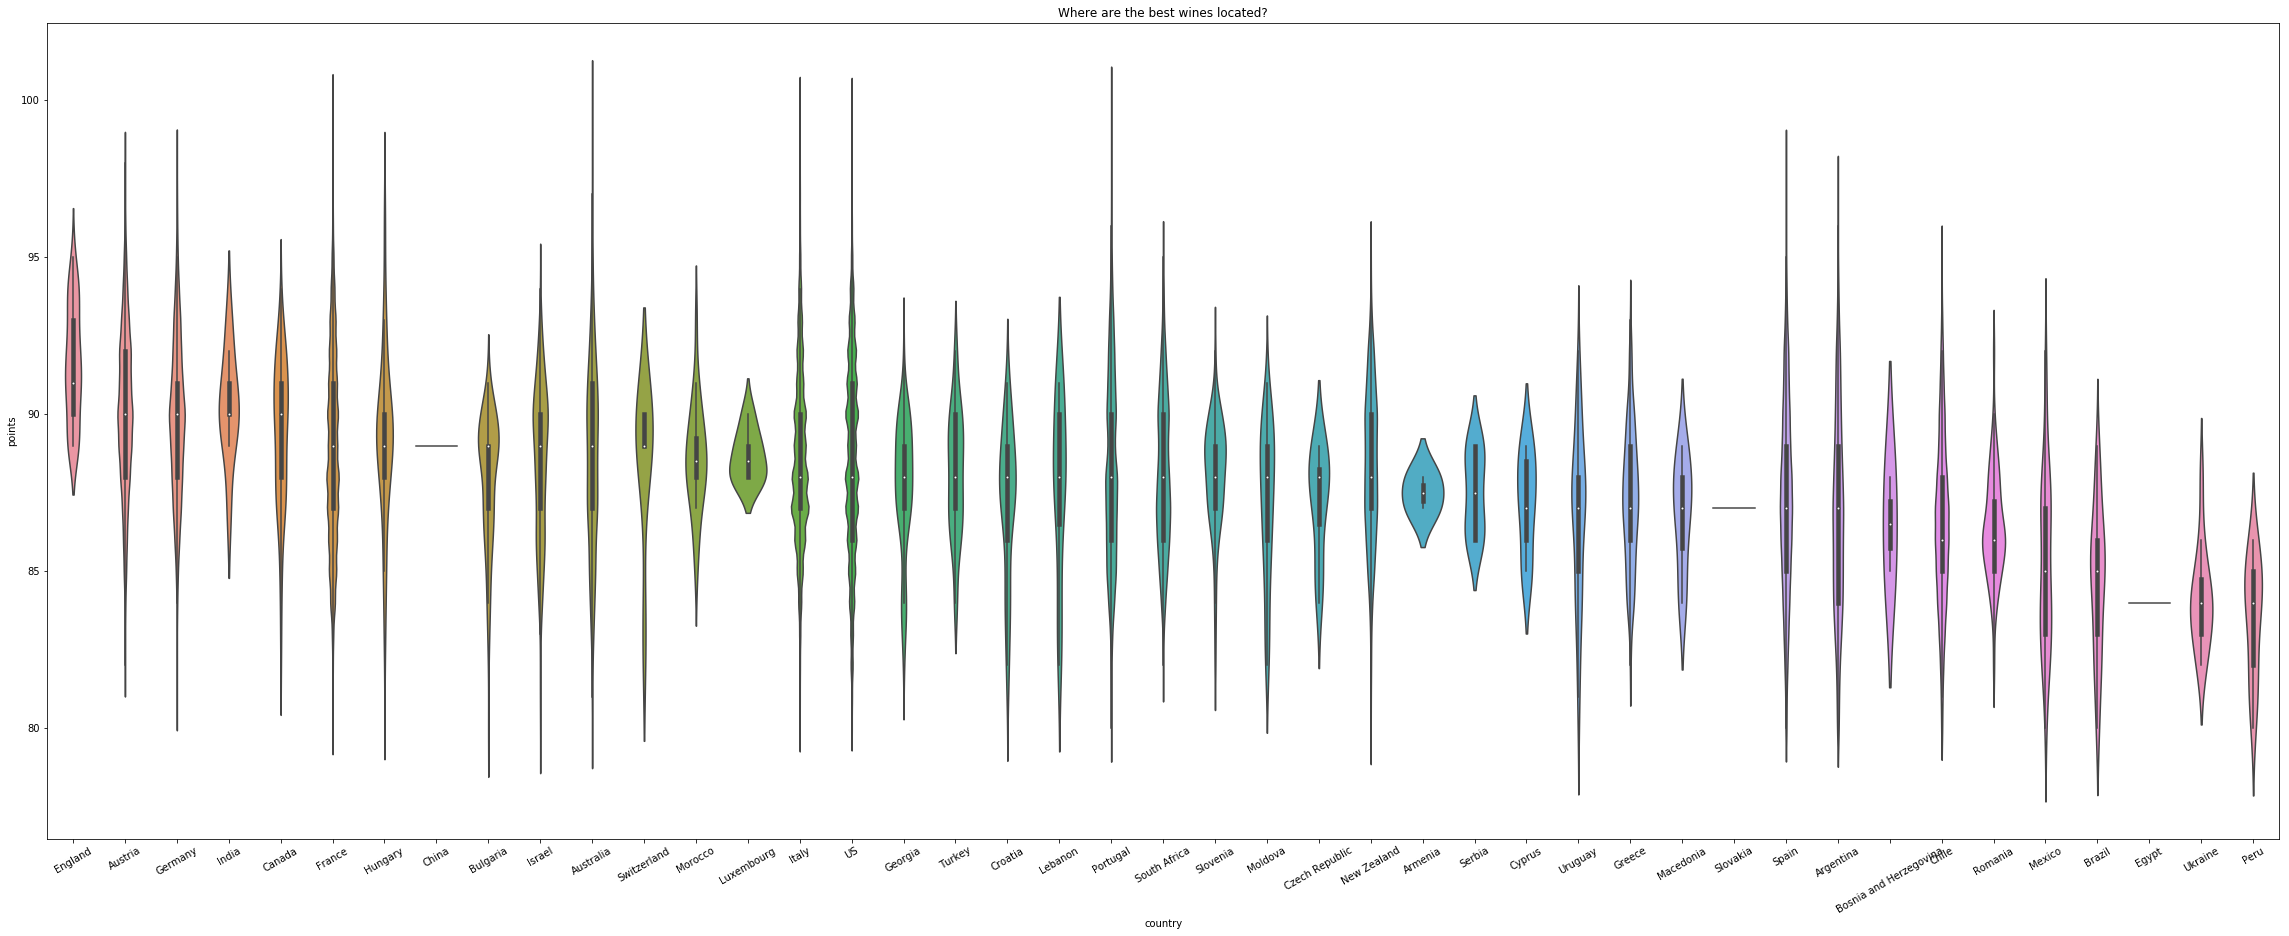

In [4]:
# violin plot of country and points
plt.figure(figsize=(40,15))
decOrder = winereviews.groupby(by=["country"])["points"].median().sort_values(ascending=False).index
vplot = sns.violinplot(data=winereviews,x='country',y='points',order=decOrder)
vplot.set_xticklabels(labels = vplot.get_xticklabels(), rotation=30)
plt.title('Where are the best wines located?')

When people think of wine they think of France. Here I explore the distribution of wines across various countries using a violin plot. These plots are ordered by the median. Surprisingly, France is not the top based on its median, but we can see that the distribution range is very long. England is the country with the highest median. We do see a gradual decrease in the medians of wine price. However, the distributions have various ranges.

Here we encode violinplots to compare distributions. As we've learned, using boxplots for multiple distribution comparisons can be misleading. I encode color here as a redundant way to identify the countries. The mark we use is an area for the violinplots as we are not only concerned with the length of the distribution, but also where in the distribution a majority of the reviews are located. I also use a point mark for the median to identify the median. The channel I encode for the violin plot is primarily position. The same is for the points.

### Dataset preprocessing

After further inspection of the data set, my computer several errors when attempting to manipulate the non-text data. I attribute this to the sparsity of the dataset. However, in its raw form, trying to convert the dataframe from sparse to dense proved to be very difficult

In [5]:

winereviews.drop(['title'],axis=1,inplace=True)

In [6]:
winereviews['variety'] = np.where(winereviews['variety'].isin(winereviews['variety'].value_counts().loc[winereviews['variety'].value_counts()<=5].index),'Other',winereviews['variety'])
winereviews['winery'] = np.where(winereviews['winery'].isin(winereviews['winery'].value_counts().loc[winereviews['winery'].value_counts()<=5].index),'Other',winereviews['winery'])
winereviews['region_1'] = np.where(winereviews['region_1'].isin(winereviews['region_1'].value_counts().loc[winereviews['region_1'].value_counts()<=5].index),'Other',winereviews['region_1'])
winereviews['province'] = np.where(winereviews['province'].isin(winereviews['province'].value_counts().loc[winereviews['province'].value_counts()<=5].index),'Other',winereviews['province'])
winereviews['region_2'] = np.where(winereviews['region_2'].isin(winereviews['region_2'].value_counts().loc[winereviews['region_2'].value_counts()<=5].index),'Other',winereviews['region_2'])





In [7]:
X_train, X_test, y_train, y_test = train_test_split(winereviews.drop('points',axis=1),winereviews['points'],test_size=0.2)

In [8]:
# get the mean of quantitative variables by the mean of wine from each country
meanPrice = X_train.groupby('country').mean().reset_index().rename(columns={'price':'mean price'})

# do on train data
X_train = X_train.merge(meanPrice,how='left',on='country')
X_train['price'] = np.where(pd.isna(X_train['price']),X_train['mean price'],X_train['price'])
X_train.drop('mean price',axis=1,inplace=True)
X_train['price'] = np.log(X_train['price'])

# do on test data
X_test = X_test.merge(meanPrice,how='left',on='country')
X_test['price'] = np.where(pd.isna(X_test['price']),X_test['mean price'],X_test['price'])
X_test.drop('mean price',axis=1,inplace=True)
X_test['price'] = np.log(X_test['price'])

In [9]:
# compare the pearson correlation coefficient for both log transform of price and no log transform

slopeLog, interceptLog, r_valueLog, p_valueLog, std_errLog = linregress(x=np.log(winereviews['price'].loc[pd.notna(winereviews['price'])]),y=winereviews['points'].loc[pd.notna(winereviews['price'])])
slope, intercept, r_value, p_value, std_err = linregress(x=winereviews['price'].loc[pd.notna(winereviews['price'])],y=winereviews['points'].loc[pd.notna(winereviews['price'])])

print((r_valueLog, p_valueLog),(r_value,p_value))

(0.61184950198314036, 0.0) (0.41616674186062252, 0.0)


In [10]:
# remove taster information 
X_train.drop(['taster_name','taster_twitter_handle'],axis=1,inplace=True)
X_test.drop(['taster_name','taster_twitter_handle'],axis=1,inplace=True)
X_train

country                                        description  \
0         Argentina  Strawberry and herbal aromas are decent but a ...   
1            Greece  This Limnio, Mavrotragano and Mavroud blend is...   
2           Austria  Notes of peardrop and lemon are immediately ap...   
3                US  This 100% varietal wine comes from Dineen, Sev...   
4       New Zealand  The new project of Erica and Kim Crawford (yes...   
5                US  There's not much overt fruit on the nose of th...   
6                US  The 11th vintage of Abacela's Albariño is a ra...   
7             Italy  This opens with aromas of spirits, underbrush,...   
8                US  This blend of Mourvèdre, Carignane and Syrah i...   
9                US  A pretty nose of violets, cherry and pepper st...   
10               US  Nervy, herbal aromas and vivid grapefruit alon...   
11        Australia  Once past the sticker shock, enjoy this wine f...   
12            Chile  Maybe a little more ripe and heady than some o...   
13           France  The first mouthful reveals a wine that is just...   
14            Italy  This precious expression made by the dynamic R...   
15               US  An extremely good deal, this wine will keep bo...   
16            Chile  Snappy grapefruit and tangerine aromas are cle...   
17            Chile  Lavishly oaked, the fruit here struggles to ma...   
18               US  This is a warm rich enveloping wine that opens...   
19            Spain  Jammy, ripe blueberry and blackberry aromas be...   
20               US  An extraordinarily elegant wine that will sati...   
21               US  This is a show-stopping blend of 71% Cabernet ...   
22               US  Smooth and round from the start, with aromas o...   
23            Italy  This has mocha, game and black-skinned berry a...   
24               US  This is thick, quite ripe and full-bodied wine...   
25               US  Comes down on the hard, rough side of the Peti...   
26           France  This is a textured wine that's rich and round....   
27         Portugal  This is a smooth, rich and rounded wine. It is...   
28               US  There's a lack of balance, with thin, slightly...   
29         Portugal  Grown in the southern part of the Minho, close...   
...             ...                                                ...   
103946           US  Subtle, spicy oak influences mingle beautifull...   
103947           US  Finding a good Anderson Valley Pinot Noir for ...   
103948        Italy  This extremely simple but pleasantly fresh whi...   
103949       France  The wine is herbal, structured, boasting the f...   
103950           US  Crushed blackberries compete with a hearty bou...   
103951           US  Fermented and aged in stainless steel, this si...   
103952    Argentina  This is a cuddly, jammy, ripe Malbec with mapl...   
103953        Italy  Picolit is a rare and precious dessert wine th...   
103954      Germany  Notes of pineapple and tangerine skin perfume ...   
103955           US  A wonderful wine, one of the best Petite Verdo...   
103956        Chile  After a gritty, fruity smelling opening, this ...   
103957     Portugal  This is so rustic that it has lost its fruit. ...   
103958        Spain  Floral and fruity smelling, this also has note...   
103959      Georgia  Aromatic, with notes of black tea leaves, sand...   
103960       France  From vineyards near Bandol, close to the Medit...   
103961        Italy  A small percentage of Teroldego is added to th...   
103962       France  The wine is structured and firm with considera...   
103963           US  With this wine, Dolce cements its status as Ca...   
103964       France  A thin wine that is all dry tannins and not en...   
103965       France  This Chardonnay is soft, with attractive and g...   
103966           US  A sweet, soft wine, very ripe, almost porty. T...   
103967           US  This refreshing rosé, just slightly dilute, br...   
103968          

These charts show the number of null values for these two columns, region_1 and region_2. What we see is that for region 1, a large majority of the records are not nan. However, in region 2 we see that a majority (60%) of the records are null values. 

I also look at the individual differences in the distributions of no location vs a specified location for each region variable. We see little difference betwee both groups. 

In [11]:
# extract descriptions to be set aside.

trainDesc = X_train['description'].copy(deep=True)
testDesc = X_test['description'].copy(deep=True)

X_train.drop('description',axis=1,inplace=True)
X_test.drop('description',axis=1,inplace=True)

In [12]:
X_train_sparse = X_train.to_sparse()
X_test_sparse = X_test.to_sparse()

In [13]:
X_train_sparse = pd.get_dummies(X_train_sparse,sparse=True)
X_test_sparse = pd.get_dummies(X_test_sparse,sparse=True)

In [15]:
gc.collect()

1239

### Text Processing

Reviews will provide a lot of insight regarding how good a wine is. We need to preprocess the data by following these steps. 

1. Tokenize the data.
2. Remove stop words
2. Create tf-idf matrix where the documents are each description 

In [14]:
def textPreprocessing(data):
    dataCopy= data.copy(deep=True)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    dataCopy = dataCopy.str.lower()
    translator = str.maketrans('', '', string.punctuation)

    dataCopy = dataCopy.apply(lambda x: x.translate(translator))
    dataCopy = dataCopy.apply(lambda x: pattern.sub('',x))
    #dataCopy = dataCopy.apply(lambda x: word_tokenize(x))
    return dataCopy.values

trainPreprocessed = textPreprocessing(trainDesc)
testPreprocessed = textPreprocessing(testDesc)



In [15]:
tfidf = TfidfVectorizer()
tfidf.fit(trainPreprocessed)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [16]:
train_tfidf = tfidf.transform(trainPreprocessed)
test_tfidf = tfidf.transform(testPreprocessed)

## SVD

We can use SVD to get dense representations of our data. This will speed up computation and perhaps uncover interesting relationships within the tf-idf matrix.

In [20]:
def numComponentsSVD(data,n=10000):
    svd = TruncatedSVD(n_components=n)
    svd.fit(data)
    sns.lineplot(x=list(range(1,n+1)),y=np.cumsum(svd.explained_variance_ratio_))

In [21]:
#numComponentsSVD(train_tfidf)

This plot shows cumulative proportion for the explained variance. It seems we reach 90% explained variance a little after 9000. However to gain 10% of accuracy we need to double our number of components. Let's use 4000 components.

In [17]:
svd = TruncatedSVD(n_components=4000)
svd.fit(train_tfidf)
trainSVD = pd.SparseDataFrame(svd.transform(train_tfidf))
testSVD = pd.SparseDataFrame(svd.transform(test_tfidf))

## Combine Data together

In [18]:
X_train_SVD= X_train.reset_index(drop=True).merge(trainSVD.reset_index(drop=True),how='left',left_index=True,right_index=True)
X_test_SVD= X_test.reset_index(drop=True).merge(testSVD.reset_index(drop=True),how='left',left_index=True,right_index=True)


## Models

In [20]:
lasso_RS = RandomizedSearchCV(estimator=Lasso(),param_distributions={'alpha':np.random.rand(100)*10},n_iter=20,scoring='mean_absolute_error')
ridge_RS = RandomizedSearchCV(estimator=Ridge(),param_distributions={'alpha':np.random.rand(100)*10},n_iter=20,scoring='mean_absolute_error')

In [ ]:
lasso_RS.fit(X_train_SVD,y_train)